In [1]:
from cppbridge import *
from mcmc_analytics import *

In [2]:
%load_ext autoreload
%autoreload 2

# Inferring parameters with EHMM samplers for Poisson model 2

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification
Here we will try to recover the parameters of the same non-linear SSM we used in the experiments with Poisson model 2 with known parameters (see `sampling_bimodal.ipynb` notebook). To do that we will specify the priors for each of the parameters driving the model: $a_i$ and $\rho$ for transition model and $\sigma_i$ for the observation model.

Out chosen priors are as follows:
* $a_{i}\sim\mathrm{U}(-1,1)$: for VAR(1) process we need our coefficients to be between -1 and 1
* $\rho\sim\mathrm{U}(0,1)$
* $\sigma_{i}\sim\mathcal{N}(0,\sigma^{2})$
where $\sigma^{2}$ is a large number to make the prior vague

In [3]:
# Set up the transition model with unknown parameters
T = 500
n = 15
A = DiagonalMatrixParam()
aa = 0.
bb = 1.
A.parametrize(n, DistributionType.UNIFORM, (aa, bb), minx=aa, maxx=bb, varscale=8)
Q = SymmetricMatrixParam()
a = 0.
b = 1.
x_var = 1.
Q.parametrize(n, DistributionType.UNIFORM, (a, b), x_var, minx=a, maxx=b)
# Prior mean is always zero
prior_mean = np.zeros(n)
# The prior covariance will be re-calculated for each newly accepted parameters, including for the first iteration 
# so below will not be used but still required to intialize the class 
Q_init = np.eye(n)
trm = TransitionSpec(A, Q, prior_mean, Q_init)

In [4]:
# Set up the observation model with unknown parameters
sigma = VectorParam()
mu = 1
var = 20
sigma.parametrize(n, DistributionType.NORMAL, (mu, np.sqrt(var)))
obsm = ObservationSpec(ModelType.BIMODAL_POISSON, sigma)

In [5]:
# We also specify the true values of parameters:
params_names = ["$a$", "$\\rho$", "$\sigma$"]
true_values = dict(zip(params_names, [0.9, 0.7, 0.8]))

## Sampler specification
### Embedded HMM sampling scheme
In these experiments we will only be using EHMM sampler.

In [6]:
# Specify EHMM scheme
nupd = 50  # number of parameter updates between the scheme runs
pool_sz = 80
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_size=pool_sz, num_parameter_updates=nupd, flip=True)

## Observations
We need the observations, on which to run the samplers. The data we use is the synthetic data, generated in `models.ipynb` notebook. In this experiemtns we will try and recover the parameters used to generate that data as well as the latent states.

In [7]:
model = "gauss_poiss2_3225125971228064704"
dataprovider = model + "_data.h5"
dataspec = Data(dataprovider)

## Simulation    
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. As in the case when we ran the model with known parameters, here we also set $\mathbf{x}_0=\mathbf{1}$ and run 5 simulations for $10 000$ iterations each, starting with the different seed for randomisation.

In [8]:
n_iter_ehmm = 10000
x_init = np.ones((n, T))
seeds = np.array([2, 10, 1e2, 1e4, 1e5], dtype=int)
scales_ehmm = np.array([0.05, 0.2, 0.025, 0.01])
reverse = False
flip = True
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

In [9]:
# Simulation with EHMM sampler
ehmm_session_name = f"bp_paramsampl_ehmm80_flip_v3"
mcmc_ehmm_bp = MCMCsession(ehmm_session_name)
if mcmc_ehmm_bp.hasResults():
    mcmc_ehmm_bp.loadResults()
else:
    mcmc_ehmm_bp.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_bp.run()

Loading results for seed100...		Done
Loading results for seed10000...		Done
Loading results for seed2...		Done
Loading results for seed10...		Done
Loading results for seed100000...		Done


---
## Analysis of the results
### Overview

In [10]:
nsamples = (1 + reverse) * (n_iter_ehmm + 1)
ehmm_burnin = int(0.1 * nsamples)  # <-- as we run on reversed sequence, too, there will be twice as many samples
ehmm_samples = mcmc_ehmm_bp.getSamples(ehmm_burnin)
psamples = mcmc_ehmm_bp.getParamSamples(ehmm_burnin, params_names)

In [50]:
ac_ehmm = getACF(mcmc_ehmm_bp.samples, ehmm_samples, lags=nsamples-1)
taus_ehmm = 1 + 2 * np.sum(ac_ehmm, axis=2)
meantaus_ehmm = np.mean(taus_ehmm)

In [51]:
allpsamples = {k:v[:,np.newaxis] for k, v in mcmc_ehmm_bp.param_samples.items()}
ac_params = getACF(allpsamples, psamples.values[:,np.newaxis], lags=nsamples-1)
taus_params = 1 + 2 * np.sum(ac_params, axis=2)
meantaus_params = np.mean(taus_params)

In [52]:
ehmm_met_acc = 100 * np.mean(
    [acc[:T].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_bp.acceptances.items()])
ehmm_shift_acc = 100 * np.mean(
    [acc[T + 1:].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_bp.acceptances.items()])
ehmm_partrm_acc = 100 * np.mean([acc['trm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_bp.param_acceptances.items()])
ehmm_parobm_acc = 100 * np.mean([acc['obsm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_bp.param_acceptances.items()])
ehmm_overview = {"Num seeds": len(seeds),
                 "Num iter": n_iter_ehmm,
                 "Time per sample, ms": np.mean(list(mcmc_ehmm_bp.durations.values())) /
                                        list(mcmc_ehmm_bp.samples.values())[0].shape[0],
                 "Acceptance rate, autoregressive update, %": ehmm_met_acc,
                 "Acceptance rate, shift update, %": ehmm_shift_acc,
                 "Acceptance rate, param updates for transition model, %": ehmm_partrm_acc,
                 "Acceptance rate, param updates for observation model, %": ehmm_parobm_acc,
                 "Average autocorrelation time, states": meantaus_ehmm,
                 "Average autocorrelation time, params": meantaus_params
                 }
overview = pd.DataFrame({"EHMM on Poisson model 2": ehmm_overview})
overview

,EHMM on Poisson model 2
"Acceptance rate, autoregressive update, %",40.252571
"Acceptance rate, param updates for observation model, %",22.789120
"Acceptance rate, param updates for transition model, %",24.197760
"Acceptance rate, shift update, %",14.598692
"Average autocorrelation time, params",595.579184
"Average autocorrelation time, states",3.059436
Num iter,10000.000000
Num seeds,5.000000
"Time per sample, ms",151.648535


In [53]:
ehmm_ar = np.stack(list(mcmc_ehmm_bp.acceptances.values()), axis=1)[:T].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
ehmm_shift = np.stack(list(mcmc_ehmm_bp.acceptances.values()), axis=1)[T + 1:].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
trm_pacc = np.array([accr['trm'] for seed, accr in mcmc_ehmm_bp.param_acceptances.items()]) / (n_iter_ehmm * nupd * (1 + reverse)) 
obm_pacc = np.array([accr['obsm'] for seed, accr in mcmc_ehmm_bp.param_acceptances.items()]) / (n_iter_ehmm * nupd * (1 + reverse)) 
states = pd.DataFrame(dict(ehmm_ar=ehmm_ar, ehmm_shift=np.append(ehmm_shift, [np.nan] * len(seeds)))).describe()
params = pd.DataFrame(dict(trm_params=trm_pacc, obm_params=obm_pacc)).describe()
pd.concat([states, params], axis=1)

,ehmm_ar,ehmm_shift,trm_params,obm_params
count,2500.000000,2495.000000,5.000000,5.000000
mean,0.402526,0.145987,0.241978,0.227891
std,0.017123,0.019729,0.009946,0.007336
min,0.321754,0.086930,0.225890,0.219972
25%,0.389611,0.131967,0.239852,0.224132
50%,0.398762,0.144245,0.245688,0.226716
75%,0.414169,0.156619,0.246636,0.229102
max,0.451997,0.250914,0.251822,0.239534


### Test equality of parameters

In [ ]:
params_ttest = ttest(psamples, list(true_values.values()))
pd.DataFrame({"p-value":params_ttest}, index=params_names)

In [54]:
pd.DataFrame({"means":psamples.mean(axis=0), "variances": psamples.var(axis=0)}, index=params_names).T 

,$a_i$,$\rho$,$\sigma_i$
means,0.873193,0.625938,0.830032
variances,0.000131,0.001004,0.001177


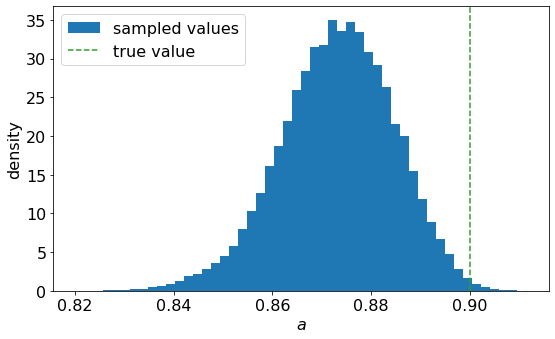

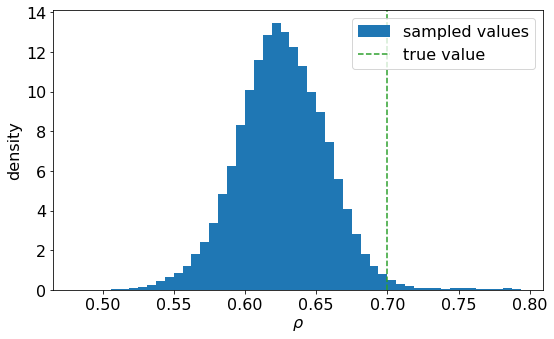

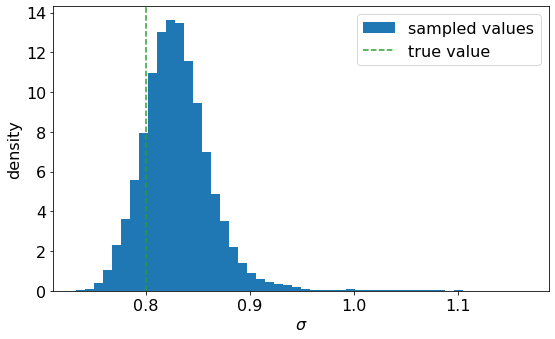

In [11]:
for pname in params_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(psamples[pname], bins=50, density=True, label=f"sampled values")
    ax.vlines(true_values[pname], 0, 1, transform=ax.get_xaxis_transform(), label="true value", linestyles='dashed', color="C2")
    ax.set_ylabel("density")
    ax.set_xlabel(pname)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH/f"bp_{pname.strip('$')}_hist.png", dpi=150, format='png')
    plt.show()

### Convergence analysis

In [184]:
epsr = getEPSR(mcmc_ehmm_bp.samples, ehmm_burnin)

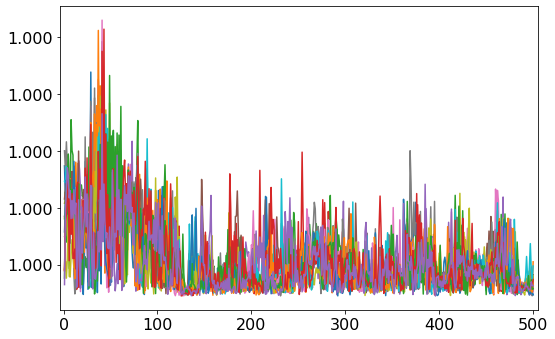

In [185]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, epsr[:, i])
ax.set_xmargin(0.01)
ax.locator_params(axis='y', nbins=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# for i, tick in enumerate(ax.yaxis.get_ticklabels()):
#     if i % 2 != 0:
#         tick.set_visible(False) 
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"epsr_met_lp.png", dpi=300, format='png')
plt.show();

In [56]:
epsr_params = getEPSR(mcmc_ehmm_bp.param_samples, ehmm_burnin)
pd.DataFrame({"EPSR": epsr_params}, index=params_names)

,EPSR
$a_i$,1.079766
$\rho$,1.034043
$\sigma_i$,1.037611


### Autocorrelation

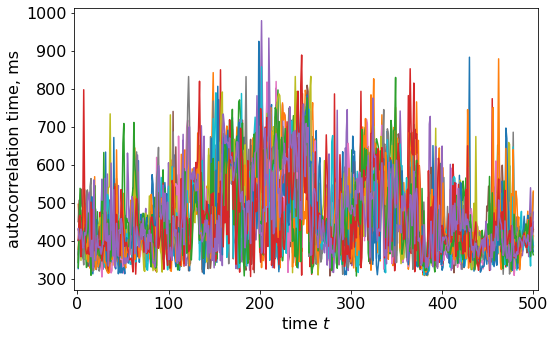

In [57]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, taus_ehmm[i, :]*overview.loc['Time per sample, ms', 'EHMM on Poisson model 2'])
ax.set_xmargin(0.01)
ax.set_xlabel("time $t$")
ax.set_ylabel("autocorrelation time, ms")
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"taus_ehmm_lp.png", dpi=300, format='png')
plt.show();

In [12]:
t = 250
d = 5

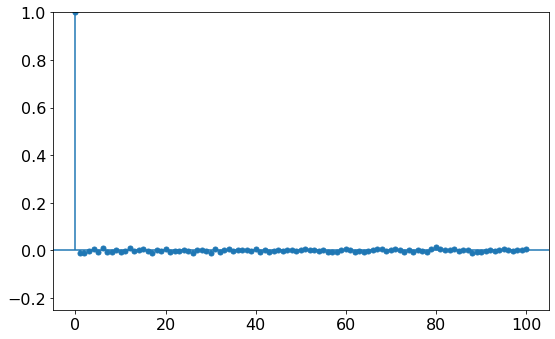

In [59]:
fig, ax = plt.subplots(figsize=(8,5))
plotACF(ac_ehmm, t, d, ax, nlags=100)
ax.set_ylim(-0.25,1)
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/f"acf_ehmm_{t}-{d}_lp.png", dpi=300, format='png')
plt.show();

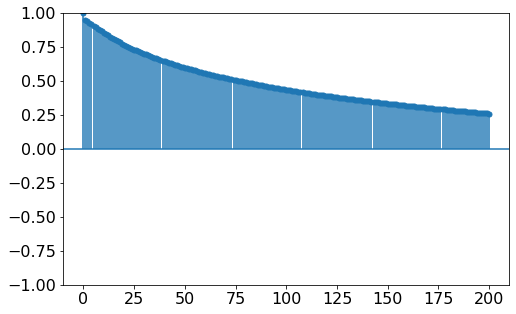

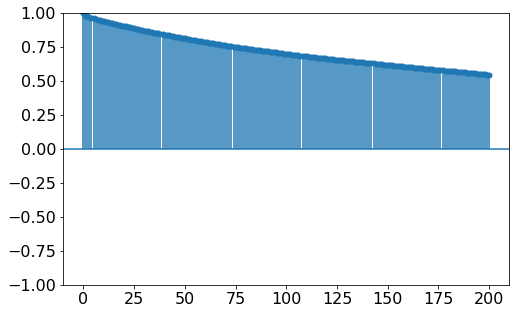

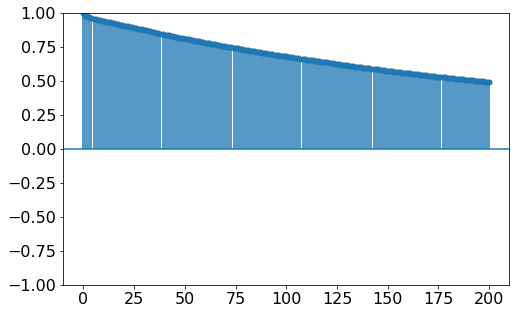

In [60]:
for idx, _ in enumerate(params_names):
    fig, ax = plt.subplots(figsize=(8, 5))
    plotACF(ac_params, 0, idx, ax, nlags=200)

### Trace plots

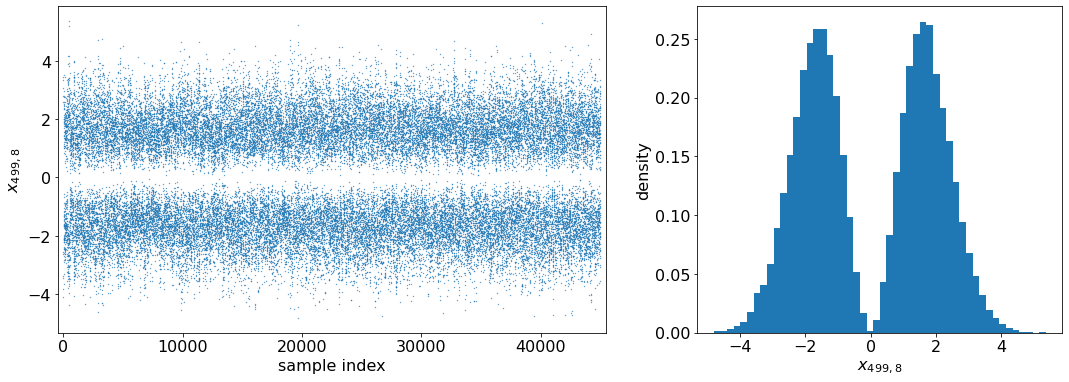

{}

In [61]:
plotTrace(ehmm_samples, t, d)

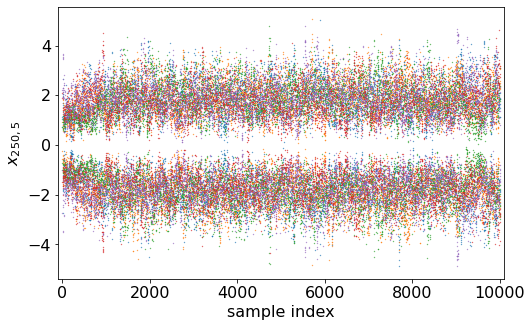

In [13]:
plotMixing(mcmc_ehmm_bp.samples, t, d, save="paraminf_bp")

In [14]:
# Compare with samplinf when params are known
comp_session_name = f"ehmm80_reverse_gauss_poiss2_3225125971228064704"
mcmc_comp = MCMCsession(comp_session_name)
mcmc_comp.loadResults()
comp_samples = mcmc_comp.getSamples(ehmm_burnin)

Loading results for seed10000...		Done
Loading results for seed100...		Done
Loading results for seed10...		Done
Loading results for seed1...		Done
Loading results for seed100000...		Done


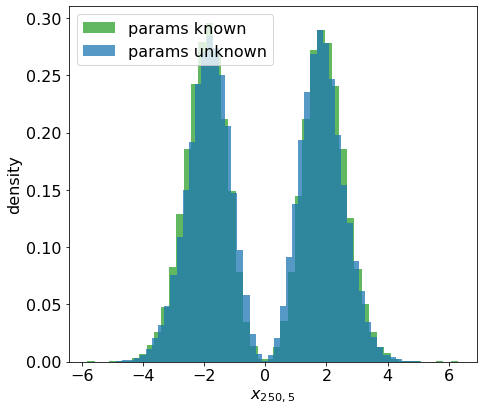

In [16]:
fig, ax = plt.subplots(figsize=(7,6))
ax.hist(comp_samples[:, t, d], bins=50, density=True, label=f"params known", alpha=0.75, color='C2')
ax.hist(ehmm_samples[:, t, d], bins=50, density=True, label=f"params unknown", alpha=0.75, color='C0')
ax.set_ylabel("density")
ax.set_xlabel(f"$x_{{{t},{d}}}$")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/f"paraminf_bp_comp_{t}_{d}_hist.png", dpi=150, format='png')
plt.show()

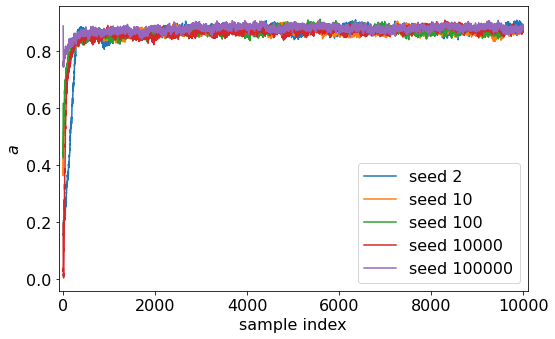

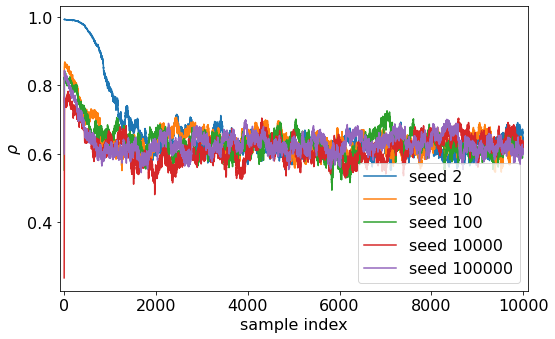

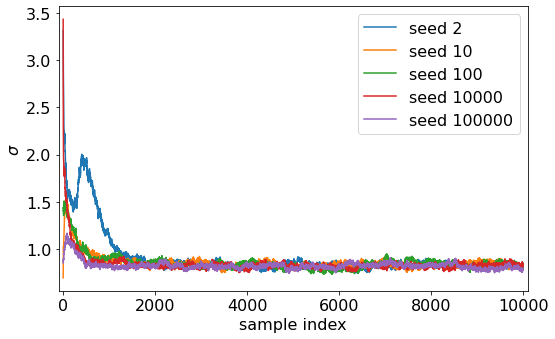

In [17]:
for idx, param_name in enumerate(params_names):
    fig, ax = plt.subplots(figsize=(8, 5))

    for seed in seeds:
        data = mcmc_ehmm_bp.getParamSamples(0, params_names, forseed=seed)
        ax.plot(data.index, data[param_name], label=f"seed {seed}")

    ax.set_xmargin(0.01)
    ax.set_ylabel(param_name)
    ax.set_xlabel("sample index")
    ax.legend()
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH / f"paraminf_bp_plotmix_{param_name.strip('$')}.png", dpi=300, format='png')
    plt.show()

### Comparison of tuning 

In [85]:
datadict = defaultdict(dict)
for item in DATA_PATH.iterdir():
    fn = str(item).split("/")[-1]
    if fn.startswith("paramtest"):
        spec = "-".join(fn.split("_")[1:4])
        if fn.endswith('specs.h5'):
            coldict = {}
            with h5py.File(item, 'r') as f: 
                coldict[('model','A mean')] = f['model/transition/A'][4:6].mean()
                coldict[('model','A var')] = (f['model/transition/A'][5] - f['model/transition/A'][4])**2 / 12
                coldict[('model','A varscale')] = f['model/transition/A'][3]
                coldict[('model','Q mean')] = f['model/transition/Q'][4:6].mean()
                coldict[('model','Q var')] = (f['model/transition/Q'][5] - f['model/transition/Q'][4])**2 / 12
                coldict[('model','Q varscale')] = f['model/transition/Q'][3]
                coldict[('model','C mean')] = f['model/observation/C'][4]
                coldict[('model','C var')] = f['model/observation/C'][5]**2
                coldict[('model','C varscale')] = f['model/observation/C'][3]
                coldict[('sampler', 'seed')] = f['simulation/seeds'][0]
                coldict[('sampler', 'npu')] = f['sampler'].attrs['num_param_updates']
                coldict[('sampler', 'scaling')] = f['simulation/scaling'][2:]
            datadict[spec].update(coldict)
        else:
            coldict = {}
            with h5py.File(item, 'r') as f:
                mcmc_name = "_".join(fn.split("_")[:-2])
                mcmc = MCMCsession(mcmc_name)
                mcmc.loadResults()
                rev = not ("noreverse" in fn)
                burnin = int(0.1 * (1 + rev) * (n_iter_ehmm + 1))
                samples = mcmc.getSamples(burnin)
                psamples = mcmc.getParamSamples(burnin, params_names)
                allpsamples = {k:v[:,np.newaxis] for k, v in mcmc.param_samples.items()}
                ac_params = getACF(allpsamples, psamples.values[:,np.newaxis], lags=1000)
                taus_params = 1 + 2 * np.sum(ac_params, axis=2)
                meantaus_params = np.mean(taus_params)
                coldict = {("params", f"{pn} mean"): pv for pn, pv in psamples.mean(axis=0).to_dict().items()}
                coldict.update({("params", f"{pn} var"): pv for pn, pv in psamples.var(axis=0).to_dict().items()})
                coldict.update({("params", f"{pn} HDR"): np.array([f"({x[0]:.2f},{x[1]:.2f})" 
                                                                   for x in getHDR(ps, bins=1000, kde=True)]).squeeze()
                                for pn, ps in psamples.items()})
                coldict.update({("params", "trm acc"): acc['trm'] for _, acc in mcmc.param_acceptances.items()})
                coldict.update({("params", "obm acc"): acc['obsm'] for _, acc in mcmc.param_acceptances.items()})
                coldict.update({("params", "mean ACT"): meantaus_params})
                coldict.update({("states","$x_{0,0}$ mean"): samples[:,0,0].mean(), ("states","$x_{0,0}$ std"): samples[:,0,0].std()})
            datadict[spec].update(coldict)
df = pd.DataFrame.from_dict(datadict)

Loading results for seed200434834...		Done
Loading results for seed200434834...		Done
Loading results for seed200434834...		Done
Loading results for seed100...		Done
Loading results for seed100...		Done
Loading results for seed200434834...		Done
Loading results for seed200434834...		Done
Loading results for seed200434834...		Done
Loading results for seed100...		Done
Loading results for seed100...		Done
Loading results for seed100...		Done
Loading results for seed100...		Done
Loading results for seed200434834...		Done
Loading results for seed200434834...		Done
Loading results for seed100...		Done
Loading results for seed200434834...		Done
Loading results for seed100...		Done


In [86]:
from functools import reduce

def inHDR(hdr, val):
    hdr = [float(v) for v in hdr[1:-1].split(",")]
    lo, hi = np.min(np.abs(hdr)), np.max(np.abs(hdr))
    return lo <= abs(val) <= hi

delete = []
for en, er in df.items():
    for pn in params_names:
        hdr = er.loc[('params', f'{pn} HDR')]
        notin = True
        if hdr.size > 1:
            notin = reduce(lambda x, y: not x and not y, [inHDR(intrvl, true_values[pn]) for intrvl in hdr], notin)
        else:
            notin &= not inHDR(str(hdr), true_values[pn])
        if notin:
            print(f"Delete {en} due to {pn} out of HDR")
            delete.append(en)
            break

Delete v3b-ehmm80-flip due to $a_i$ out of HDR
Delete v4cb-ehmm80-flip due to $\rho$ out of HDR
Delete v4bb-ehmm80-flip due to $a_i$ out of HDR
Delete v4b-ehmm80-flip due to $\rho$ out of HDR
Delete v4ca-ehmm80-flip due to $a_i$ out of HDR
Delete v4a-ehmm80-flip due to $a_i$ out of HDR
Delete v3d-ehmm80-flip due to $\rho$ out of HDR
Delete v3ee-ehmm80-flip due to $\rho$ out of HDR
Delete v4c-ehmm80-flip due to $a_i$ out of HDR
Delete v4bd-ehmm80-flip due to $a_i$ out of HDR
Delete v4bc-ehmm80-flip due to $a_i$ out of HDR
Delete v3e-ehmm80-flip due to $\rho$ out of HDR
Delete v3c-ehmm80-flip due to $a_i$ out of HDR
Delete v3eee-ehmm80-flip due to $a_i$ out of HDR
Delete v4ba-ehmm80-flip due to $a_i$ out of HDR
Delete v3a-ehmm80-flip due to $a_i$ out of HDR
Delete v3eea-ehmm80-flip due to $a_i$ out of HDR


In [87]:
df.sort_values(('params','trm acc'), axis=1, ascending=True)

v3b-ehmm80-flip v4c-ehmm80-flip v4ca-ehmm80-flip  \
model   A mean                      0.0             0.5              0.5   
        A var                  0.333333        0.083333         0.083333   
        A varscale                 40.0             8.0              8.0   
        Q mean                      0.5             0.5              0.5   
        Q var                  0.083333        0.083333         0.083333   
        Q varscale                  1.0             1.0              1.0   
        C mean                      1.0             1.0              1.0   
        C var                      16.0            20.0             20.0   
        C varscale                  1.0             1.0              1.0   
sampler seed                        100       200434834        200434834   
        npu                          50              50               50   
        scaling            [0.02, 0.01]    [0.04, 0.01]     [0.03, 0.01]   
params  $a_i$ mean             0.874012        0.874556         0.871437   
        $\rho$ mean            0.622653        0.623915         0.625623   
        $\sigma_i$ mean        0.821042        0.834863         0.832147   
        $a_i$ var              0.000075         0.00009         0.000109   
        $\rho$ var             0.000591        0.000779         0.000717   
        $\sigma_i$ var         0.000595        0.000674         0.000568   
        $a_i$ HDR           (0.86,0.89)     (0.86,0.89)      (0.85,0.89)   
        $\rho$ HDR          (0.57,0.67)     (0.57,0.68)      (0.57,0.68)   
        $\sigma_i$ HDR      (0.77,0.87)     (0.78,0.89)      (0.78,0.88)   
        trm acc                   40817           64808            99267   
        obm acc                  124910          115805           114540   
        mean ACT             571.996938      471.597067       369.701599   
states  $x_{0,0}$ mean         0.001213        0.000931         0.001272   
        $x_{0,0}$ std          1.176959        1.082166         1.068625   

                        v3a-ehmm80-flip v4cb-ehmm80-flip v3eea-ehmm80-flip  \
model   A mean                      0.0              0.5               0.0   
        A var                  0.333333         0.083333          0.333333   
        A varscale                  4.0              8.0               3.0   
        Q mean                      0.5              0.5               0.5   
        Q var                  0.083333         0.083333          0.083333   
        Q varscale                  1.0              1.0               1.0   
        C mean                      1.0              1.0               1.0   
        C var                      16.0             20.0              20.0   
        C varscale                  1.0              1.0               1.0   
sampler seed                        100        200434834               100   
        npu                          50               50                50   
        scaling            [0.02, 0.01]    [0.025, 0.01]      [0.02, 0.01]   
params  $a_i$ mean             0.875591         0.881554          0.875333   
        $\rho$ mean            0.628782         0.633805          0.608646   
        $\sigma_i$ mean        0.826651         0.839588          0.834624   
        $a_i$ var              0.000075         0.000073          0.000095   
        $\rho$ var             0.001141         0.000571          0.001093   
        $\sigma_i$ var         0.000693         0.000662           0.00066   
        $a_i$ HDR           (0.86,0.89)      (0.86,0.90)       (0.86,0.89)   
        $\rho$ HDR          (0.56,0.70)      (0.59,0.68)       (0.54,0.67)   
        $\sigma_i$ HDR      (0.78,0.88)      (0.79,0.89)       (0.79,0.89)   
        trm acc                  118718           120498            135279   
        obm acc                  125105           114828            114191   
        mean ACT             540.577656        364.29704        473.681925   
states  $x_{0,0}$ mea